In [85]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
import re
from sklearn.cluster import KMeans
from scipy.ndimage import binary_dilation

In [38]:
path = r'C:\Users\attic\HLS_Kelp\imagery\Isla_Vista_Kelp\11SKU'
granules = os.listdir(path)
if 'DEM' in granules[0]:
    granule = granules[1]
else:
    granule = granules[0]
img_path = os.path.join(path,granule)
files = os.listdir(img_path)
print(files)
desired_bands = ['B02','B03','B04','B05','B06','B07'] #2,3,4,5,6,7]
pattern = re.compile(r'\.(' + '|'.join(desired_bands) + r')\.tif$')
img_files = [f for f in files if re.search(pattern, f)]
print(img_files)
geotiff_path = os.path.join(img_path, img_files[0])

['HLS.L30.T11SKU.2018106T183324.v2.0.B01.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B02.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B03.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B04.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B05.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B06.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B07.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B09.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B10.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B11.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.Fmask.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.SAA.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.SZA.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.VAA.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.VZA.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0_metadata.csv']
['HLS.L30.T11SKU.2018106T183324.v2.0.B02.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B03.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B04.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B05.tif', 'HLS.L30.T11SKU.2018106T183324.v2.0.B06.tif', 'HLS.L30.T11SKU.2018106T1

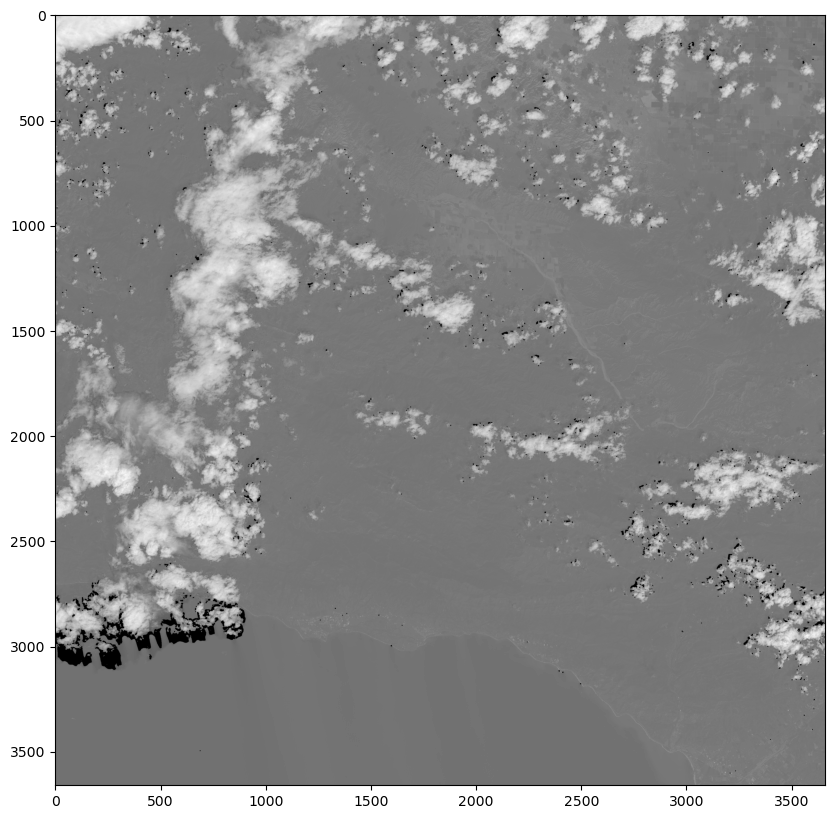

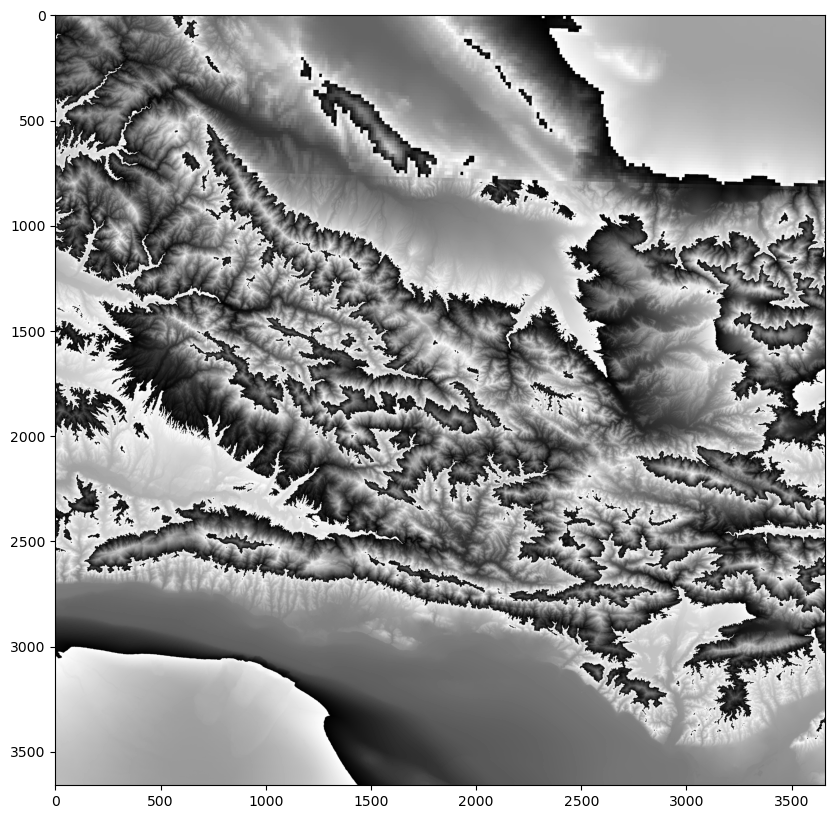

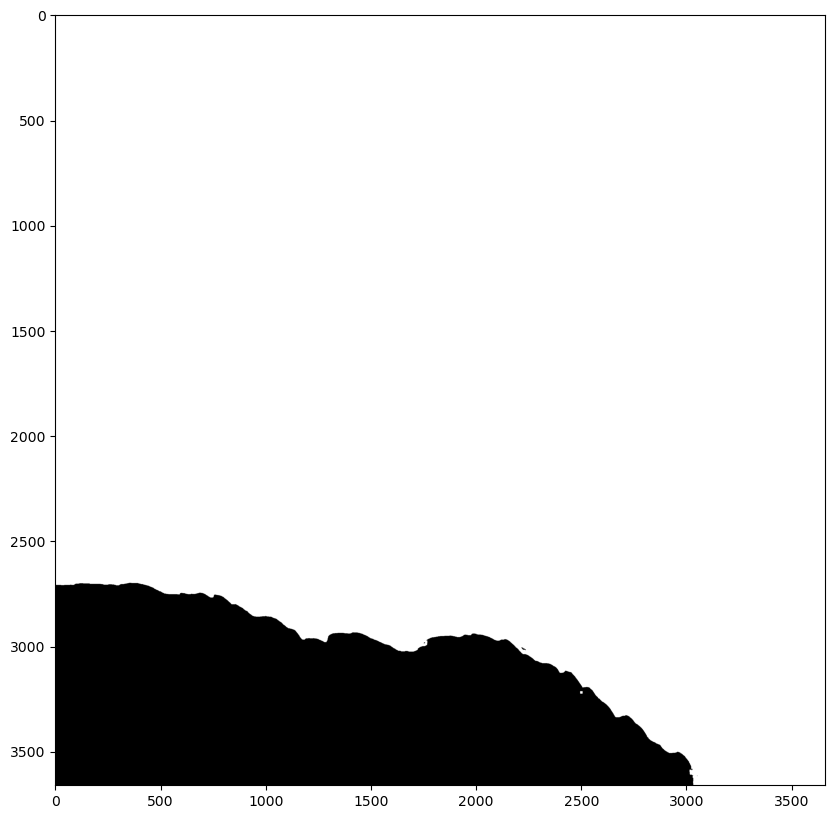

In [108]:

with rasterio.open(geotiff_path) as dst:   
    hls = dst.read()
    dem = rasterio.open(os.path.join(path, '11SKU_DEM.tiff'))
    if (dem.crs != dst.crs):
        reprojected_dem = np.zeros((hls.shape[1], hls.shape[2]), dtype=hls.dtype)
        reproject(
            source=dem.read(),
            destination=reprojected_dem,
            src_transform=dem.transform,
            src_crs=dem.crs,
            dst_transform=dst.transform,
            dst_crs=dst.crs,
            resampling=Resampling.nearest)
    hls_flat = np.squeeze(hls, axis=0)
    plt.figure(figsize=(10, 10))
    plt.imshow(hls_flat, cmap='gray')
    plt.show()   

if reprojected_dem.any():
    plt.figure(figsize=(10, 10))
    plt.imshow(reprojected_dem*100, cmap='gray')
    plt.show()
struct = np.ones((10,10))
land_mask = binary_dilation(reprojected_dem > 0, structure = struct)

plt.figure(figsize=(10, 10))
plt.imshow(land_mask, cmap='gray')
plt.show()

In [109]:
landsat_masked = np.ma.masked_where(land_mask, hls_flat, fill_value=0)
plt.figure(figsize=(8, 8))
plt.imshow(landsat_masked, cmap='gray')
plt.show()

TypeError: masked_where() got an unexpected keyword argument 'fill_value'

In [110]:
img_bands = []
for file in img_files:
    with rasterio.open(os.path.join(img_path,file)) as src:
        img_bands.append(np.where(land_mask, 0, src.read(1)))

img = np.stack(img_bands, axis=0)

n_bands, height, width = img.shape
img_2D = img.reshape(img.shape[0], -1).T #classifier takes 2D array of band values for each pixel 
print("First 10 pixels w/ band values...")
print(img_2D[0:6,:])




First 10 pixels w/ band values...
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


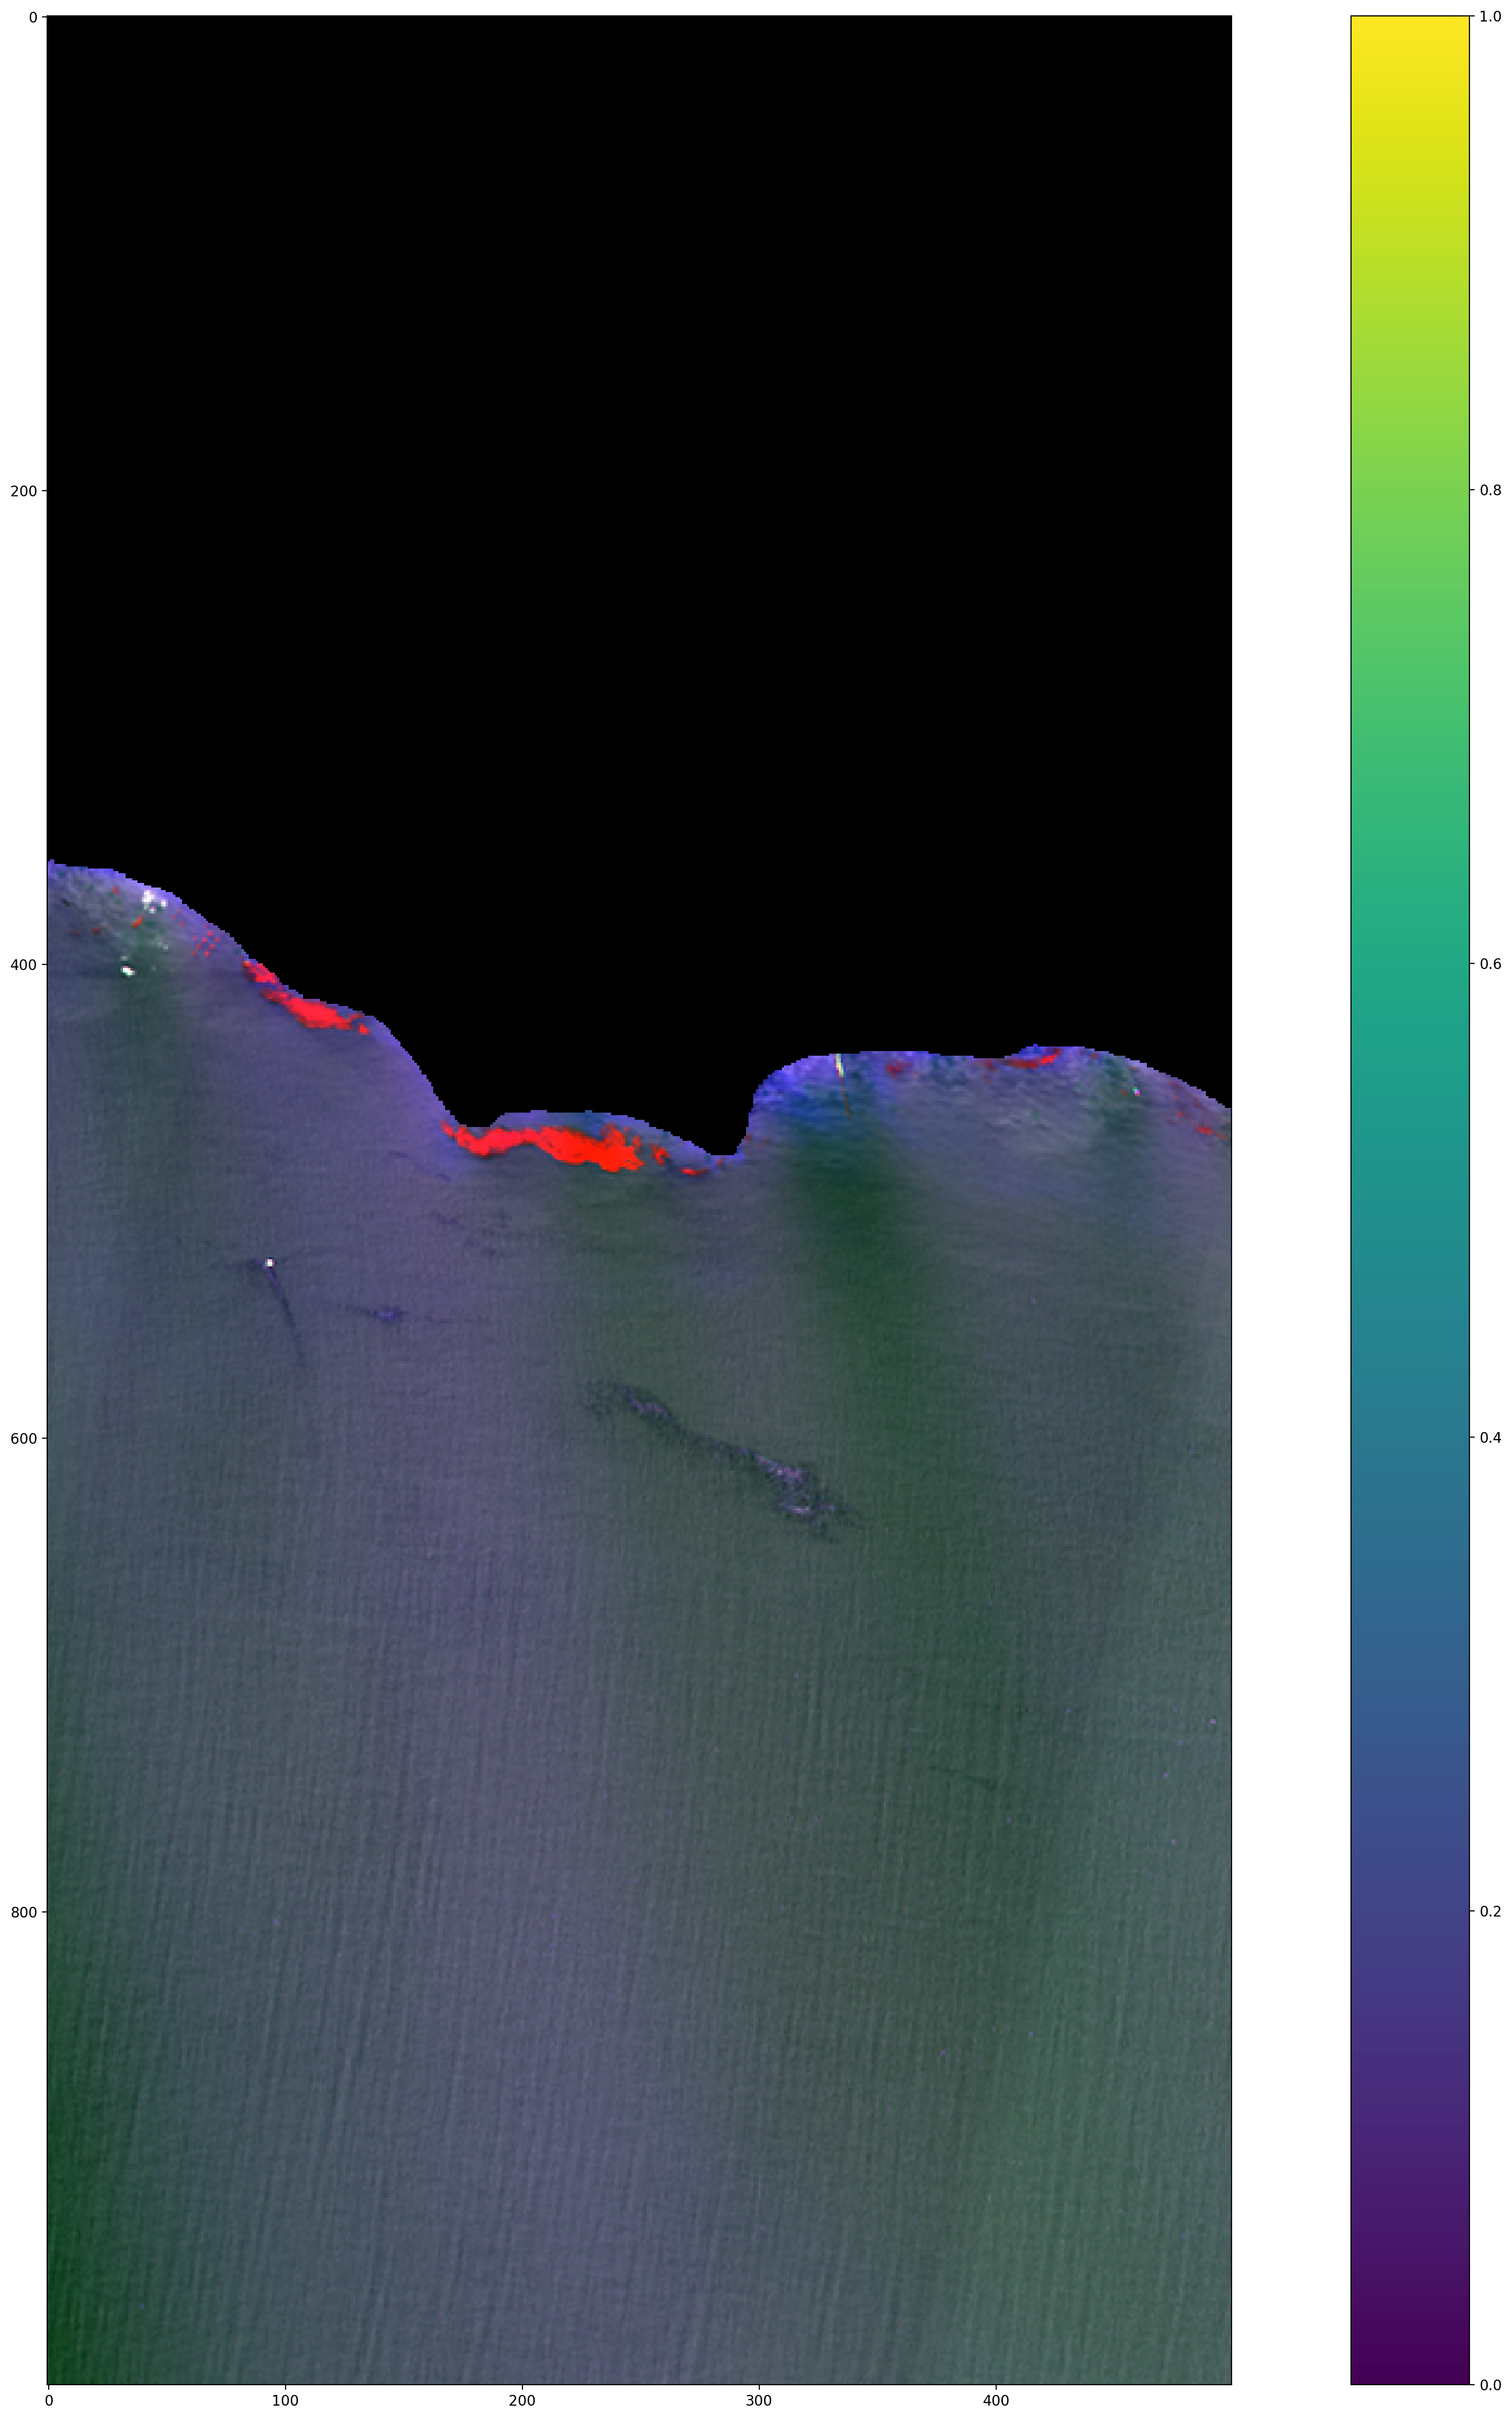

In [117]:
rgb_image = np.stack([img[3], img[4], img[1]], axis=-1)
rgb_image = rgb_image / 635.0
rgb_image = rgb_image[2500:3500,1000:1500]
plt.figure(figsize=(30, 30), dpi=200)
plt.imshow(rgb_image)
plt.colorbar()
plt.show()

In [112]:
img_sum = img_2D.sum(axis=1)
img_2D_normalized  = img_2D / img_sum[:,None]
img_2D_normalized = (img_2D_normalized * 255)
img_2D_normalized = img_2D_normalized.astype(np.uint8)
print(img_2D_normalized[0:6,:])

C:\Users\attic\AppData\Local\Temp\ipykernel_24292\2233904316.py:2: RuntimeWarning: divide by zero encountered in divide
  img_2D_normalized  = img_2D / img_sum[:,None]
C:\Users\attic\AppData\Local\Temp\ipykernel_24292\2233904316.py:2: RuntimeWarning: invalid value encountered in divide
  img_2D_normalized  = img_2D / img_sum[:,None]


[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


C:\Users\attic\AppData\Local\Temp\ipykernel_24292\2233904316.py:4: RuntimeWarning: invalid value encountered in cast
  img_2D_normalized = img_2D_normalized.astype(np.uint8)


In [121]:
print(len(img_2D[2,:]))

6


In [123]:
n_clusters = 50
bands_to_use = [2, 3, 4]  # Adjust according to your specific bands of interest
new_img_2D = img_2D[:, bands_to_use]
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(new_img_2D)
clusters_reshaped = clusters.reshape((height, width))


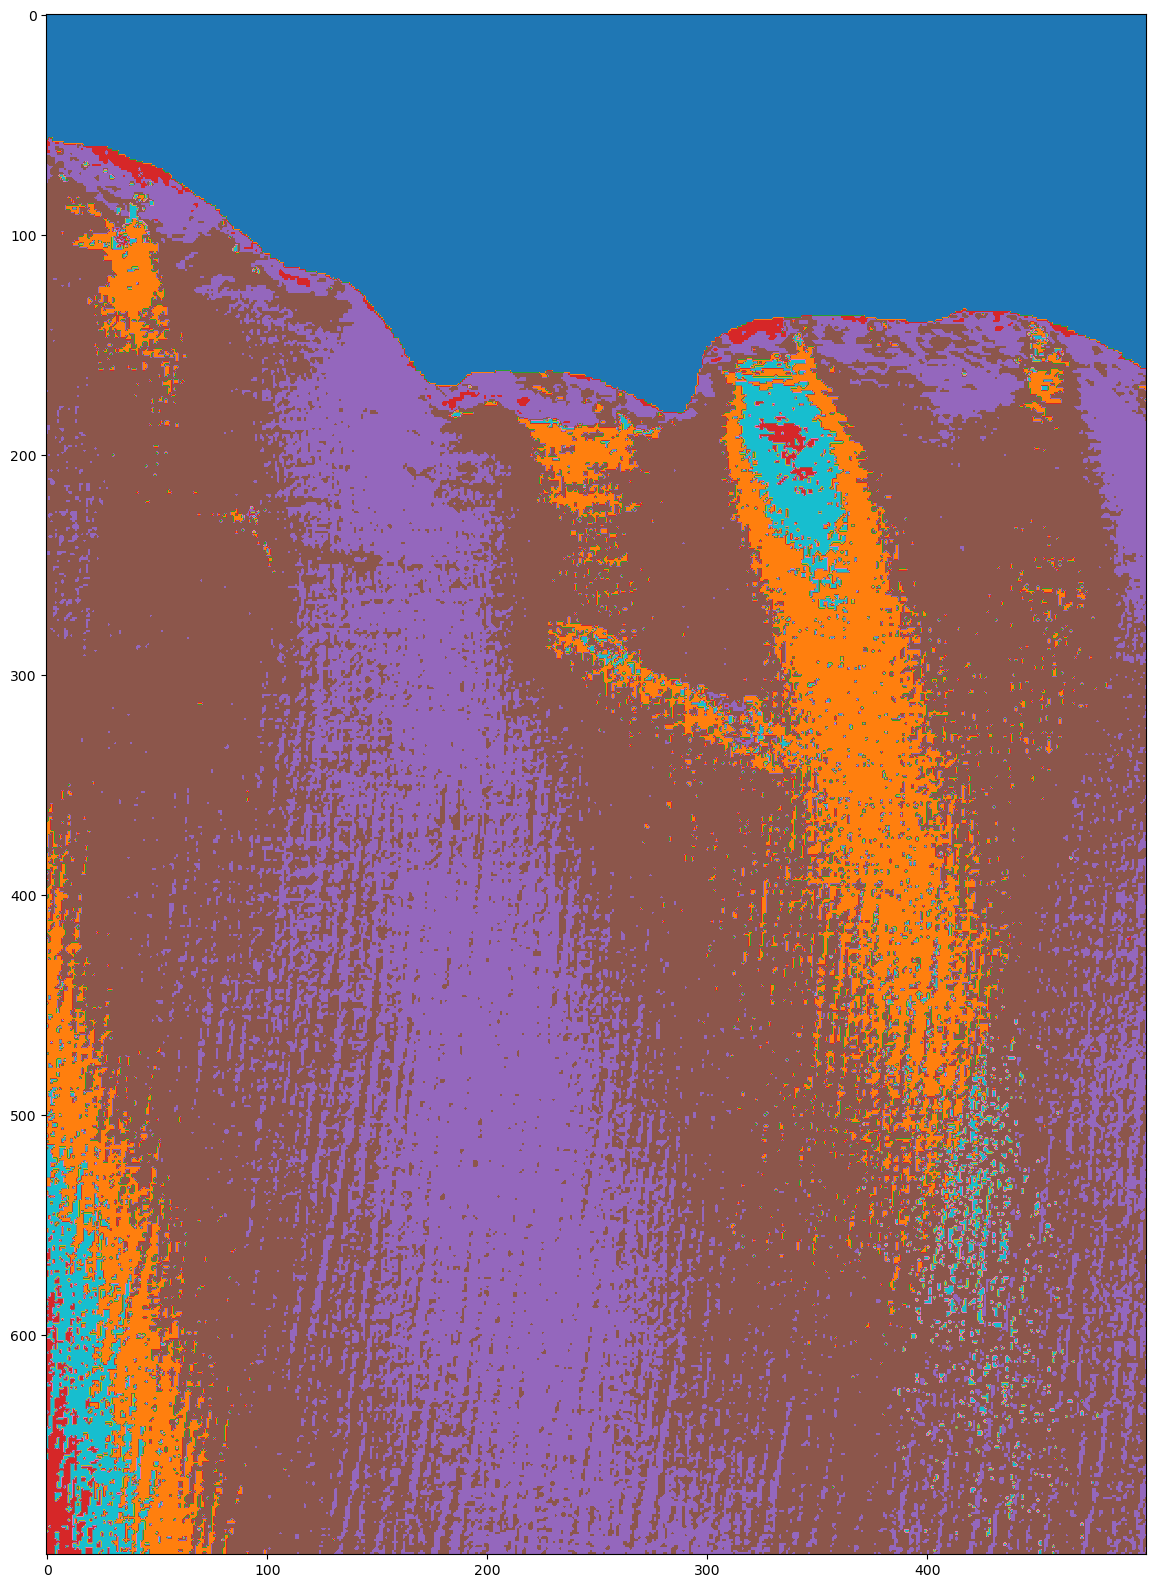

In [124]:
mask_vals = []
#ask_vals += [0,34,37,85,86,87,88,89,31]
# 30 is water
kelp_vals = [1]
mask = np.isin(mask_vals, kelp_vals, invert=True)
clusters_cropped = clusters_reshaped[2800:3500, 1000:1500]
new_clusters = clusters_cropped.astype(float) 
mask = np.isin(clusters_cropped, mask_vals)

new_clusters[mask] = np.nan
plt.figure(figsize=(20, 20))
plt.imshow(new_clusters, cmap='tab10')
plt.show()